# Artificial Neural Network For Multi-Classification - Python Implementation 

Diaa Ahmed Abdelzaher Abdelaziz
1902558@eng.asu.edu.eg

### General steps for a classification problem:
1. Importing Necessary Libraries
2. Read, analyze and visualize the dataset
3. Define helper functions
4. Prepare the dataset for training
5. Build neural network model
6. Train and plot the accuracy of the model

**1. Importing Necessary Libraries**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

**2. Read, analyze and visualize the dataset**

In [2]:
data = pd.read_csv('winequality-red.csv', sep=';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Our dataset contain **1559** data samples and **12** columns/features with numerical float values.

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

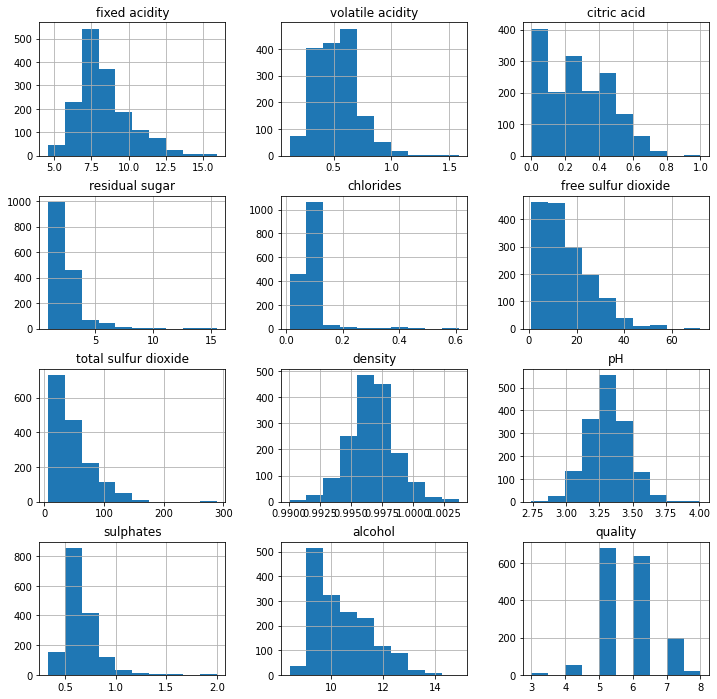

In [4]:
data.hist(figsize=(12,12))

The target feature is ***quality*** and it has 6 discrete values {3,4,5,6,7,8}

**3. Define helper functions**

**shuffle_split_data** function which split the dataset into training and testing sets according to defined split ratio

In [5]:
def shuffle_split_data(X, y, ratio):
    arr_rand = np.random.rand(X.shape[0])
    split = arr_rand < np.percentile(arr_rand, ratio)
    #split = np.random.choice(range(X.shape[0]), int((ratio/100)*X.shape[0]))
    X_train = X[~split]
    y_train = y[~split]
    X_test =  X[split]
    y_test = y[split]

    #print (len(X_train), len(y_train), len(X_test), len(y_test))
    return X_train, y_train, X_test, y_test

**encode_and_bind** function which apply One Hot encoding on the target feature

In [6]:
def one_hot_encode(array):
    """Convert an iterable of indices to one-hot encoded labels."""
    unique, inverse = np.unique(array, return_inverse=True)
    onehot = np.eye(unique.shape[0])[inverse]
    return onehot

**standardize_data** function which normalize the data by subtracting the mean and dividing by the 
stdev for each feature and each sample

In [7]:
def standardize_data(data):
    #Compute the mean
    data_mean = data.sum(axis=0)/data.shape[0]
    #Compute the standard deviation
    data_std = np.std(data, axis=0, dtype=np.float64)
    #Standardize the data
    data_standard = (data - data_mean)/data_std
    
    return data_standard

**4. Prepare the dataset for training**

Check for duplicates

In [8]:
duplicates = data[data.duplicated(keep=False)]
duplicates = duplicates.sort_values(by=['quality'], ascending= False)
duplicates.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
498,10.7,0.35,0.53,2.60,0.070,5.0,16.0,0.99720,3.15,0.65,11.0,8
495,10.7,0.35,0.53,2.60,0.070,5.0,16.0,0.99720,3.15,0.65,11.0,8
290,8.7,0.52,0.09,2.50,0.091,20.0,49.0,0.99760,3.34,0.86,10.6,7
1002,9.1,0.29,0.33,2.05,0.063,13.0,27.0,0.99516,3.26,0.84,11.7,7
997,5.6,0.66,0.00,2.20,0.087,3.0,11.0,0.99378,3.71,0.63,12.8,7


In [9]:
print("There is {} duplicated datapoints in our dataset".format(data.duplicated().sum()))

There is 240 duplicated datapoints in our dataset


Duplicate Records doesn't contribue to our prediction. Rather they just increase the training size. It's usual to get rid of duplicates from our dataset.

In [10]:
data.drop_duplicates(keep = 'first', inplace = True)
print('Total {} datapoints remaining with {} features'.format(data.shape[0], data.shape[1]))

Total 1359 datapoints remaining with 12 features


In [11]:
columns = list(data.columns.values)

labels = data[columns[-1:]]
labels = np.array(labels, dtype='int64')
features = data[columns[0:-1]]
features = np.array(features, dtype='float64')

Use describe() function to show the statistics of each feature.

In [12]:
dataset = pd.DataFrame({'fixed acidity': features[:, 0], 'volatile acidity': features[:, 1], 'citric acid': features[:, 2]
                        , 'residual sugar': features[:, 3], 'chlorides': features[:, 4], 'free sulfur dioxide': features[:, 5]
                       , 'total sulfur dioxide': features[:, 6], 'density': features[:, 7], 'pH': features[:, 8]
                       , 'sulphates': features[:, 9], 'alcohol': features[:, 10]})
dataset.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


It seems that the dataset is not normalized (the mean if features not zero)  
Let's standardize the dataset

In [13]:
features_standardize = standardize_data(features)
#features_standardize = np.round(features_standardize, 6)

In [14]:
dataset_standardize = pd.DataFrame({'fixed acidity': features_standardize[:, 0], 'volatile acidity': features_standardize[:, 1]
                        , 'citric acid': features_standardize[:, 2], 'residual sugar': features_standardize[:, 3]
                        , 'chlorides': features_standardize[:, 4], 'free sulfur dioxide': features_standardize[:, 5]
                       , 'total sulfur dioxide': features_standardize[:, 6], 'density': features_standardize[:, 7]
                        , 'pH': features_standardize[:, 8], 'sulphates': features_standardize[:, 9]
                        , 'alcohol': features_standardize[:, 10]})
dataset_standardize.describe().round(decimals=4)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1359.0000,1359.0000,1359.0000,1359.0000,1359.0000,1359.0000,1359.0000,1359.0000,1359.0000,1359.0000,1359.0000
mean,-0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000
std,1.0004,1.0004,1.0004,1.0004,1.0004,1.0004,1.0004,1.0004,1.0004,1.0004,1.0004
min,-2.1370,-2.2380,-1.3933,-1.2009,-1.5423,-1.4261,-1.2225,-3.5536,-3.6765,-1.9267,-1.8789
25%,-0.6972,-0.7623,-0.9328,-0.4612,-0.3672,-0.8516,-0.7434,-0.5936,-0.6439,-0.6372,-0.8619
50%,-0.2365,-0.0518,-0.0631,-0.2392,-0.1848,-0.1813,-0.2643,-0.0048,0.0014,-0.2269,-0.2148
75%,0.5122,0.6041,0.8066,0.0567,0.0583,0.4890,0.4843,0.5947,0.5821,0.4179,0.6173
max,4.3709,5.7417,3.7228,9.5994,10.5934,5.3724,7.2514,3.7367,4.5181,7.8620,4.1304


It seems that the data is standardized, the **mean** of each feature = 0 and the **std** = 1.

Append another column of ones to the feature space which maps adding the bias

In [15]:
features_final = np.c_[ features_standardize, np.ones(features_standardize.shape[0]) ]

One Hot encode the target feature ***labels***

In [16]:
labels_final = one_hot_encode(labels)

In [17]:
#test the label array after applying hot encoding
labels_final[0]

array([0., 0., 1., 0., 0., 0.])

Let's split the dataset into training and testing sets

In [18]:
X_train, y_train, X_test, y_test = shuffle_split_data(features_final, labels_final, 50)

In [19]:
print("Training Set shape: " + str(X_train.shape))
print("Testing Set shape: " + str(X_test.shape))

Training Set shape: (680, 12)
Testing Set shape: (679, 12)


**5. Build neural network model**
#### General steps to build neural network:
1. Define the neural network structure ( # of input units,  # of hidden units, etc)
2. Initialize the model's parameters
3. Loop:
    - Implement forward propagation
    - Compute loss
    - Implement backward propagation to get the gradients
    - Update parameters


In [20]:
class ANN:
    def __init__(self, layers_size):
        self.layers_size = layers_size
        self.parameters = {}
        self.L = len(self.layers_size)
        self.n = 0
        self.costs = [] 

    def relu(self,Z):
        '''
        The ReLu activation function is to performs a threshold
        operation to each input element where values less 
        than zero are set to zero.
        '''
        return np.maximum(0,Z)

    def dRelu(self, x):
        x[x<=0] = 0
        x[x>0] = 1
        return x
    
    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)
 
    def initialize_parameters(self):
        np.random.seed(1)
 
        for l in range(1, len(self.layers_size)):
            self.parameters["W" + str(l)] = np.random.randn(self.layers_size[l], self.layers_size[l - 1]) / np.sqrt(
                self.layers_size[l - 1])
 
    def forward(self, X):
        store = {}
        
        A = X.T
        for l in range(self.L - 1):
            Z = self.parameters["W" + str(l + 1)].dot(A)
            A = self.relu(Z)
            store["A" + str(l + 1)] = A
            store["W" + str(l + 1)] = self.parameters["W" + str(l + 1)]
            store["Z" + str(l + 1)] = Z
 
        Z = self.parameters["W" + str(self.L)].dot(A) 
        A = self.softmax(Z)
        store["A" + str(self.L)] = A
        store["W" + str(self.L)] = self.parameters["W" + str(self.L)]
        store["Z" + str(self.L)] = Z
        return A, store

 
    def backward(self, X, Y, store):
        derivatives = {}
        store["A0"] = X.T

        A = store["A" + str(self.L)]
        dZ = A - Y.T
 
        dW = dZ.dot(store["A" + str(self.L - 1)].T) / self.n
        dAPrev = store["W" + str(self.L)].T.dot(dZ)

        derivatives["dW" + str(self.L)] = dW
 
        for l in range(self.L - 1, 0, -1):
            dZ = dAPrev * self.dRelu(store["Z" + str(l)])
            dW = 1. / self.n * dZ.dot(store["A" + str(l - 1)].T)
            if l > 1:
                dAPrev = store["W" + str(l)].T.dot(dZ)
 
            derivatives["dW" + str(l)] = dW
 
        return derivatives
 
    def fit(self, X, Y, learning_rate, n_iterations):
        np.random.seed(1)
 
        self.n = X.shape[0]
        self.layers_size.insert(0, X.shape[1])
        self.initialize_parameters()
        for loop in range(n_iterations):
            A, store = self.forward(X)
            cost = np.sum((Y - A.T) ** 2)/ self.n  ##Mean Square Error
            
            derivatives = self.backward(X, Y, store)
 
            for l in range(1, self.L + 1):
                self.parameters["W" + str(l)] = self.parameters["W" + str(l)] - learning_rate * derivatives[
                    "dW" + str(l)]
 
            if loop % 100 == 0:
                print("Loss: ", cost, "Train Accuracy:", self.predict(X, Y))
 
            if loop % 10 == 0:
                self.costs.append(cost)
 
    def predict(self, X, Y):
        A, cache = self.forward(X)
        y_hat = np.argmax(A, axis=0)
        Y = np.argmax(Y, axis=1)
        accuracy = (y_hat == Y).mean()
        return accuracy * 100
 
    def plot_loss(self):
        plt.figure()
        plt.plot(np.arange(len(self.costs)), self.costs)
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()

**6. Train and plot the accuracy of the model**

Set the number of neurons in hidden and ouptut layers

In [21]:
layersDims = [30, 6]

For learning_rate = 0.1

Loss:  0.8265431653608578 Train Accuracy: 32.35294117647059
Loss:  0.5208093887402137 Train Accuracy: 59.26470588235294
Loss:  0.5035208738393832 Train Accuracy: 61.1764705882353
Loss:  0.4925939227409262 Train Accuracy: 62.794117647058826
Loss:  0.48464239119310715 Train Accuracy: 63.52941176470588
Loss:  0.47812493753945545 Train Accuracy: 64.11764705882354
Loss:  0.4721271536954926 Train Accuracy: 64.41176470588236
Loss:  0.46687353209413784 Train Accuracy: 64.55882352941177
Loss:  0.46181360703714724 Train Accuracy: 64.8529411764706
Loss:  0.4567332626977856 Train Accuracy: 65.73529411764706
Train Accuracy: 66.76470588235294
Test Accuracy: 57.14285714285714


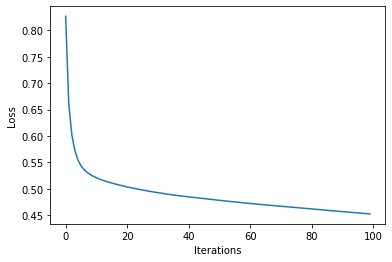

In [22]:
ann1 = ANN(layersDims)
ann1.fit(X_train, y_train, learning_rate=0.1, n_iterations=1000)
print("Train Accuracy:", ann1.predict(X_train, y_train))
print("Test Accuracy:", ann1.predict(X_test, y_test))
ann1.plot_loss()

For learning_rate = 0.05

Loss:  0.8929065327221574 Train Accuracy: 4.411764705882353
Loss:  0.5638301233676902 Train Accuracy: 56.61764705882353
Loss:  0.5319516380698833 Train Accuracy: 59.85294117647059
Loss:  0.5153169529477301 Train Accuracy: 59.85294117647059
Loss:  0.5035307146165067 Train Accuracy: 61.029411764705884
Loss:  0.4945548937734092 Train Accuracy: 62.05882352941177
Loss:  0.4878839676659328 Train Accuracy: 63.67647058823529
Loss:  0.48268714719881795 Train Accuracy: 64.41176470588236
Loss:  0.47838486782921336 Train Accuracy: 64.26470588235294
Loss:  0.474200182949223 Train Accuracy: 65.44117647058823
Train Accuracy: 66.02941176470588
Test Accuracy: 57.437407952871865


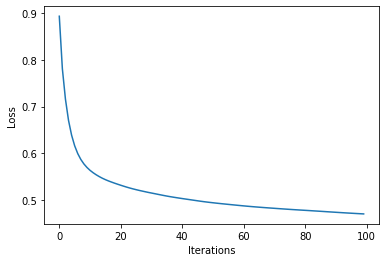

In [23]:
ann2 = ANN(layersDims)
ann2.fit(X_train, y_train, learning_rate=0.05, n_iterations=1000)
print("Train Accuracy:", ann2.predict(X_train, y_train))
print("Test Accuracy:", ann2.predict(X_test, y_test))
ann2.plot_loss()

For learning_rate = 0.01

Loss:  0.8918401846756474 Train Accuracy: 12.647058823529411
Loss:  0.7644633187245548 Train Accuracy: 46.32352941176471
Loss:  0.6765146202997322 Train Accuracy: 48.8235294117647
Loss:  0.6287759426611269 Train Accuracy: 53.088235294117645
Loss:  0.6018526712044446 Train Accuracy: 54.11764705882353
Loss:  0.5831539749332968 Train Accuracy: 57.205882352941174
Loss:  0.5686389632156069 Train Accuracy: 57.79411764705882
Loss:  0.5571811582074602 Train Accuracy: 58.6764705882353
Loss:  0.5484188704597996 Train Accuracy: 59.85294117647059
Loss:  0.541420091025964 Train Accuracy: 60.147058823529406
Train Accuracy: 60.147058823529406
Test Accuracy: 55.52282768777614


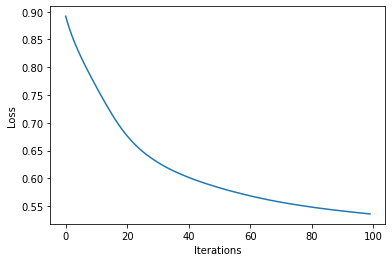

In [24]:
ann3 = ANN(layersDims)
ann3.fit(X_train, y_train, learning_rate=0.01, n_iterations=1000)
print("Train Accuracy:", ann3.predict(X_train, y_train))
print("Test Accuracy:", ann3.predict(X_test, y_test))
ann3.plot_loss()